<a href="https://colab.research.google.com/github/AnkitSingh-MLE/StockPrediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Data/S&P 500 stocks data/all_stocks_5yr.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
                open           high            low          close  \
count  619029.000000  619032.000000  619032.000000  619040.000000   
mean       83.023334      83.778311      82.256096      83.043763   
std        97.378769      98.207519      96.507421      97.389748   
min         1.620000       1.690000       1.500000       1.590000   
25%        40.220000      40.620000      39.830000      40.245000   
50%        62.590000      63.150000      62.020000      62.620000   
75

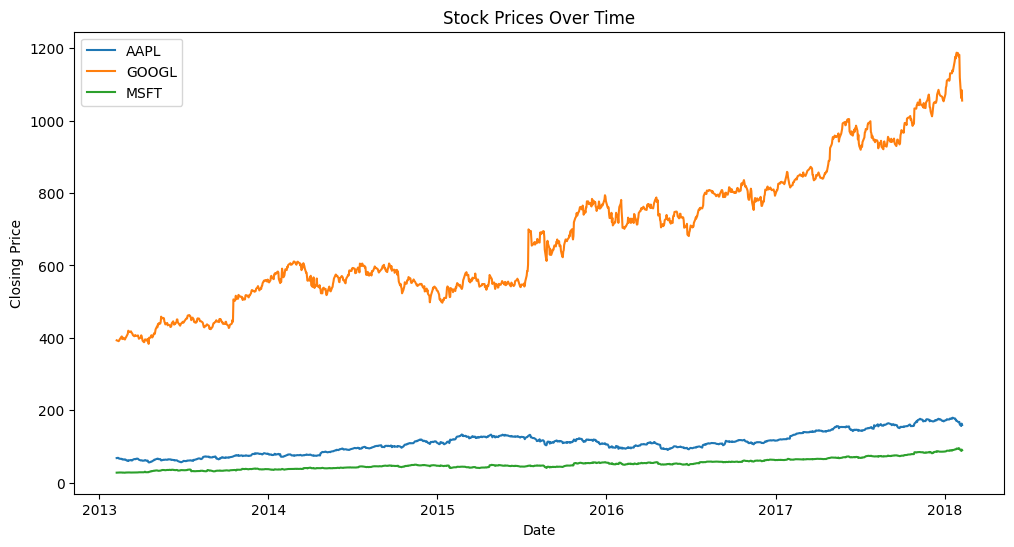

In [4]:
# Check basic information
df.info()

# Display statistical summary
print(df.describe())

#Convert the Date Column to DateTime Format
df['date'] = pd.to_datetime(df['date'])

import matplotlib.pyplot as plt

# Select a few company tickers
selected_stocks = ['AAPL', 'GOOGL', 'MSFT']

plt.figure(figsize=(12, 6))

for stock in selected_stocks:
    stock_df = df[df['Name'] == stock]
    plt.plot(stock_df['date'], stock_df['close'], label=stock)

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Prices Over Time")
plt.legend()
plt.show()



In [5]:
# Count missing values in each column
print(df.isnull().sum())

df.ffill(inplace=True)

#We calculate the 7-day and 30-day moving averages for stock closing prices
df['ma7'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=7).mean())
df['ma30'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=30).mean())

# percentage change in stock price compared to the previous day
df['daily_return'] = df.groupby('Name')['close'].pct_change()

#Compute Volatility (Rolling Standard Deviation of Returns)
df['volatility_30d'] = df.groupby('Name')['daily_return'].transform(lambda x: x.rolling(window=30).std())

#Encode Stock Names (Ticker Symbols)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['stock_id'] = encoder.fit_transform(df['Name'])
df.drop(columns=['Name'], inplace=True)


date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


In [6]:
#Shift the Target to Predict the Next 30 Days
df['close_next_30_days'] = df.groupby('stock_id')['close'].shift(-30)

# Drop Rows with NaN Values
df.dropna(inplace=True)

#Define Features & Target
# Features (same as before)
features = ['ma7', 'ma30', 'daily_return', 'volatility_30d', 'stock_id']

# Target variable: Closing price for the next 30 days
target = 'close_next_30_days'

X = df[features]
y = df[target]

#Split the Data into Training & Test Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [7]:
#Linear Regression (Baseline Model)
from sklearn.linear_model import LinearRegression

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

#Random Forest
from sklearn.ensemble import RandomForestRegressor

# Initialize and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


#XGBoost
import xgboost as xgb

# Initialize and train model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
#2: Define Evaluation Function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, model_name):
    # Predict using the model
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"📌 {model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)

    return y_pred, mae, mse, rmse, r2

In [10]:
# Model 1 Evaluation
y_pred_model1, mae1, mse1, rmse1, r2_1 = evaluate_model(lr_model, X_test, y_test, "lr_model")

# Model 2 Evaluation
y_pred_model2, mae2, mse2, rmse2, r2_2 = evaluate_model(rf_model, X_test, y_test, "rf_model")

# Model 3 Evaluation
y_pred_model3, mae3, mse3, rmse3, r2_3 = evaluate_model(xgb_model, X_test, y_test, "xgb_model")


📌 lr_model Performance:
MAE: 4.5541
MSE: 46.6083
RMSE: 6.8270
R² Score: 0.9780
----------------------------------------
📌 rf_model Performance:
MAE: 5.6300
MSE: 69.9390
RMSE: 8.3630
R² Score: 0.9671
----------------------------------------
📌 xgb_model Performance:
MAE: 5.8736
MSE: 75.7537
RMSE: 8.7037
R² Score: 0.9643
----------------------------------------


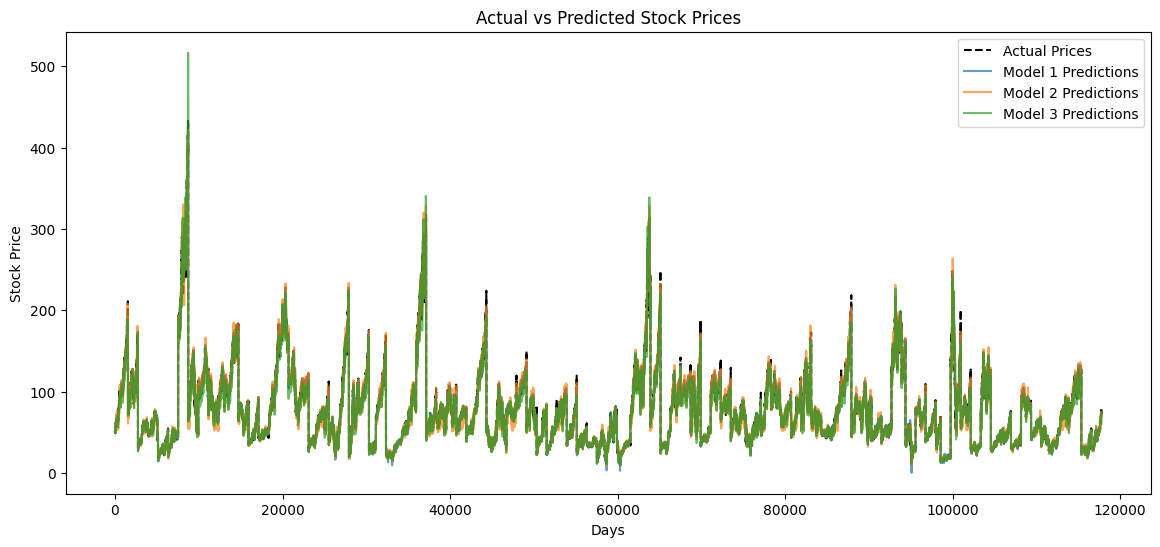

In [11]:
#Plot Actual vs Predicted Prices
plt.figure(figsize=(14, 6))

plt.plot(y_test.values, label="Actual Prices", color='black', linestyle='dashed')
plt.plot(y_pred_model1, label="Model 1 Predictions", alpha=0.7)
plt.plot(y_pred_model2, label="Model 2 Predictions", alpha=0.7)
plt.plot(y_pred_model3, label="Model 3 Predictions", alpha=0.7)

plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()


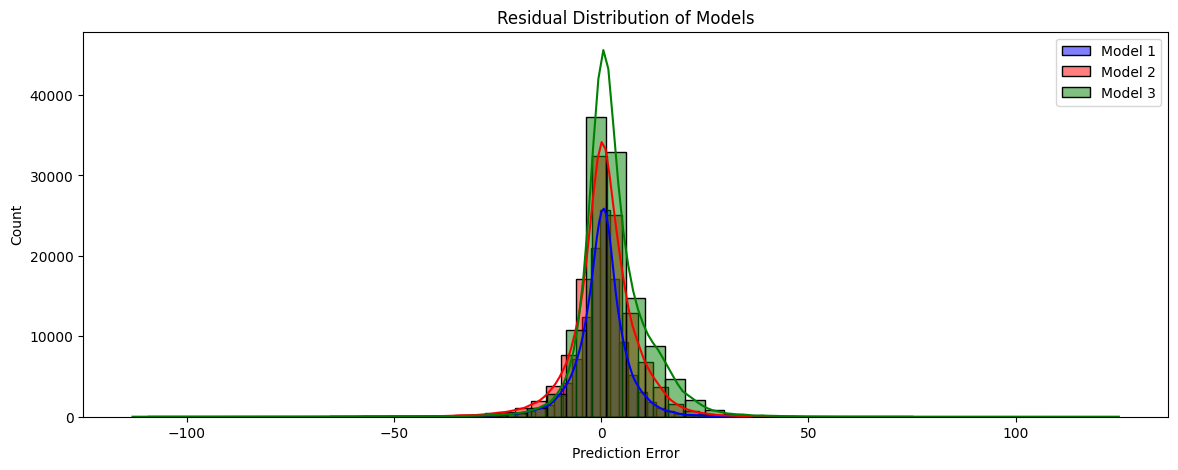

In [12]:
# Residual Plot (Errors in Predictions)
plt.figure(figsize=(14, 5))

sns.histplot(y_test - y_pred_model1, bins=50, color="blue", label="Model 1", kde=True)
sns.histplot(y_test - y_pred_model2, bins=50, color="red", label="Model 2", kde=True)
sns.histplot(y_test - y_pred_model3, bins=50, color="green", label="Model 3", kde=True)

plt.xlabel("Prediction Error")
plt.title("Residual Distribution of Models")
plt.legend()
plt.show()


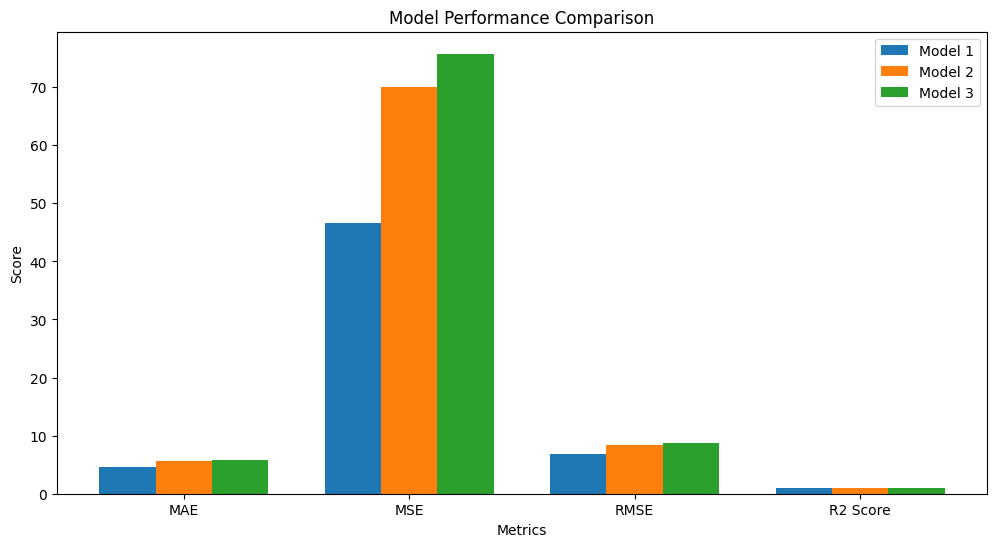

In [13]:
#Compare Metrics Using a Bar Chart
metrics = ['MAE', 'MSE', 'RMSE', 'R2 Score']
model1_scores = [mae1, mse1, rmse1, r2_1]
model2_scores = [mae2, mse2, rmse2, r2_2]
model3_scores = [mae3, mse3, rmse3, r2_3]

x = np.arange(len(metrics))
width = 0.25  # Bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width, model1_scores, width, label="Model 1")
plt.bar(x, model2_scores, width, label="Model 2")
plt.bar(x + width, model3_scores, width, label="Model 3")

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks(ticks=x, labels=metrics)
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


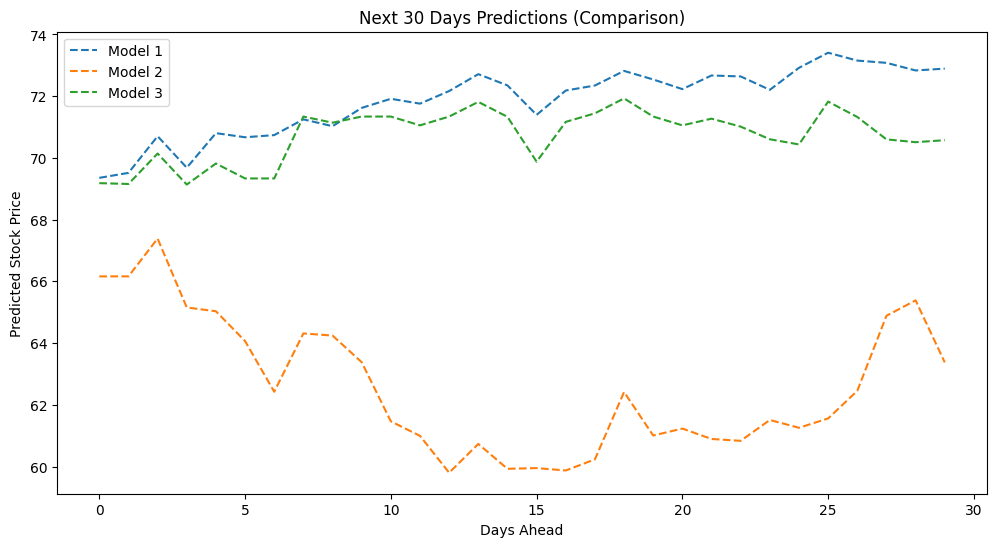

In [15]:
#Predict Next 30 Days and Compare
future_X = X_test[-30:]  # Last 30 rows for future prediction

future_pred1 = lr_model.predict(future_X)
future_pred2 = rf_model.predict(future_X)
future_pred3 = xgb_model.predict(future_X)

plt.figure(figsize=(12, 6))

plt.plot(range(30), future_pred1, label="Model 1", linestyle="dashed")
plt.plot(range(30), future_pred2, label="Model 2", linestyle="dashed")
plt.plot(range(30), future_pred3, label="Model 3", linestyle="dashed")

plt.xlabel("Days Ahead")
plt.ylabel("Predicted Stock Price")
plt.title("Next 30 Days Predictions (Comparison)")
plt.legend()
plt.show()
